In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

data_orig = pd.read_csv("/content/drive/MyDrive/DL_HW8/Google_Stock_Price_Train.csv")
data_orig.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
data_orig['Date'] = pd.to_datetime(data_orig['Date'])
date_data = data_orig['Date'].values

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


price = data_orig[['Close']]
price['Close'] = price['Close'].str.replace(',', '').astype(float)


scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


<ipython-input-25-abb7a801e062>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = price['Close'].str.replace(',', '').astype(float)
<ipython-input-25-abb7a801e062>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []


    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [ ]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3416886031627655
Epoch  1 MSE:  0.25686994194984436
Epoch  2 MSE:  0.21419765055179596
Epoch  3 MSE:  0.23331020772457123
Epoch  4 MSE:  0.18520599603652954
Epoch  5 MSE:  0.15819840133190155
Epoch  6 MSE:  0.13937072455883026
Epoch  7 MSE:  0.10515457391738892
Epoch  8 MSE:  0.06178803741931915
Epoch  9 MSE:  0.07887257635593414
Epoch  10 MSE:  0.035387758165597916
Epoch  11 MSE:  0.058851081877946854
Epoch  12 MSE:  0.060531437397003174
Epoch  13 MSE:  0.034791115671396255
Epoch  14 MSE:  0.021515659987926483
Epoch  15 MSE:  0.022706272080540657
Epoch  16 MSE:  0.02461080439388752
Epoch  17 MSE:  0.023489413782954216
Epoch  18 MSE:  0.02208508551120758
Epoch  19 MSE:  0.021326716989278793
Epoch  20 MSE:  0.02095949649810791
Epoch  21 MSE:  0.02175997756421566
Epoch  22 MSE:  0.02277250401675701
Epoch  23 MSE:  0.02097284607589245
Epoch  24 MSE:  0.017258357256650925
Epoch  25 MSE:  0.014722920022904873
Epoch  26 MSE:  0.014097939245402813
Epoch  27 MSE:  0.0140222823

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

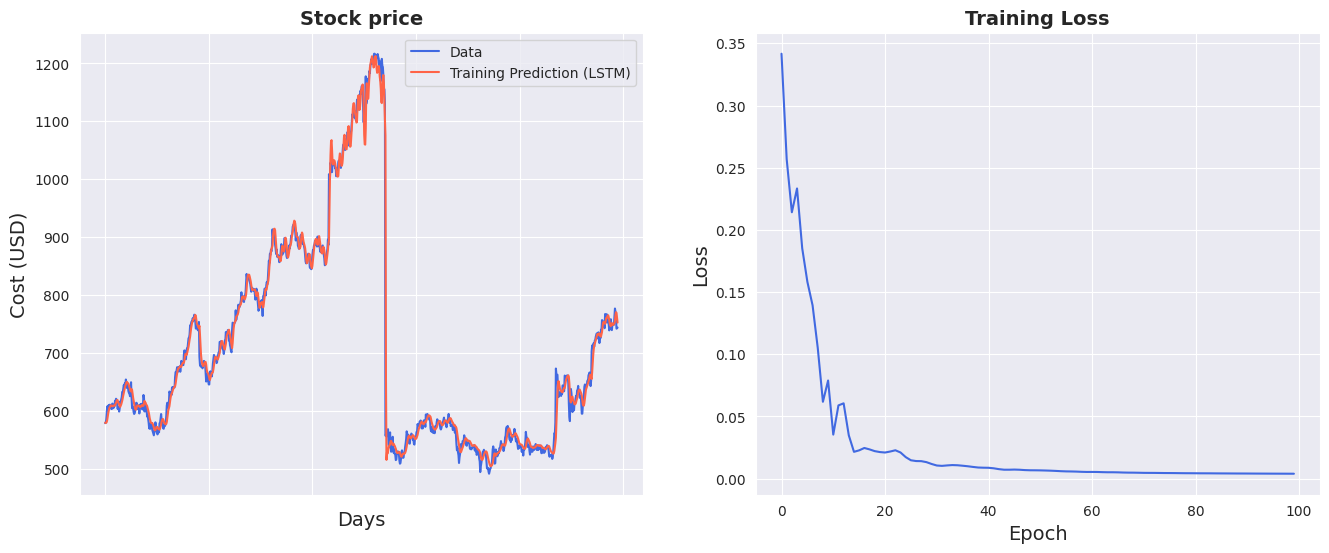

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error


y_test_pred = model(x_test)


y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())


trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 22.68 RMSE
Test Score: 12.03 RMSE


In [ ]:

trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred


testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

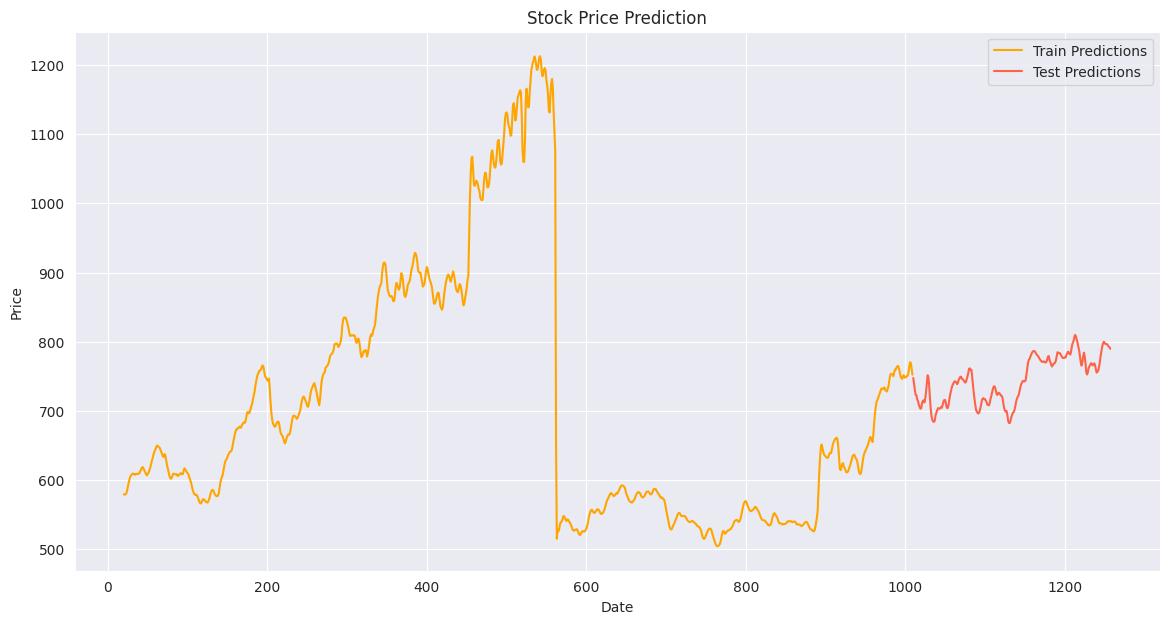

In [ ]:

trainPredictPlot = np.empty_like(price['Close'])
trainPredictPlot[:] = np.nan
trainPredictPlot[lookback:len(y_train_pred) + lookback] = y_train_pred.flatten()


testPredictPlot = np.empty_like(price['Close'])
testPredictPlot[:] = np.nan
test_start_index = len(trainPredictPlot) - len(y_test_pred)

testPredictPlot[test_start_index:] = y_test_pred.flatten()


combined_predictions = np.column_stack((trainPredictPlot, testPredictPlot))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(price.index, combined_predictions[:, 0], color='orange', label='Train Predictions')  # Train predictions
plt.plot(price.index, combined_predictions[:, 1], color='tomato', label='Test Predictions')  # Test predictions

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


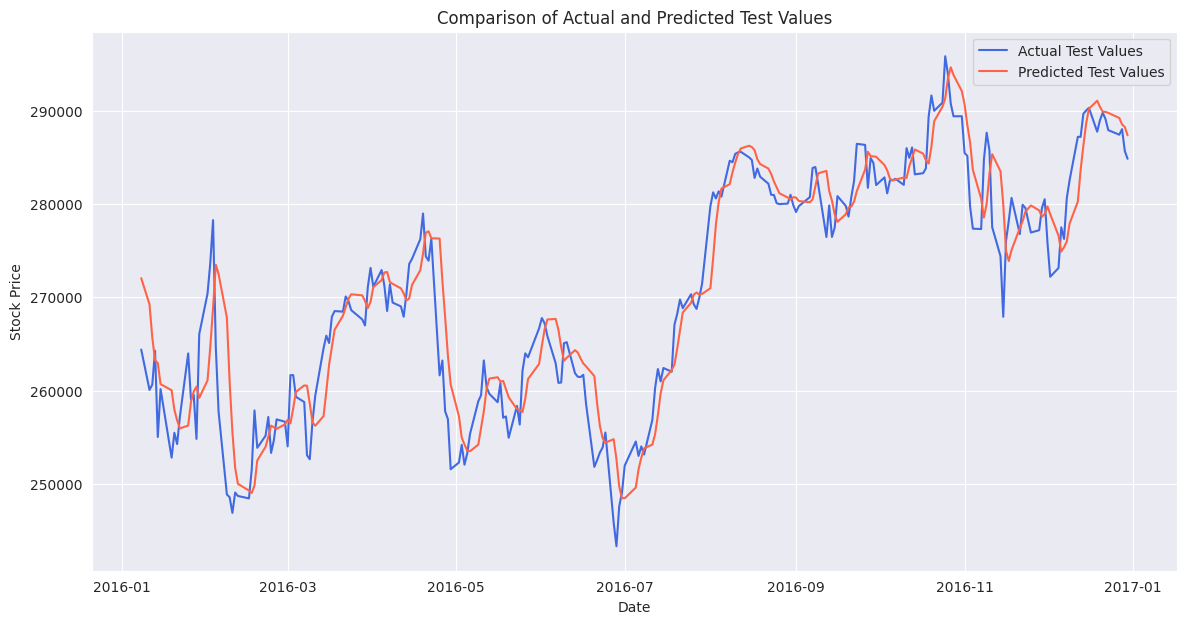

In [ ]:



test_start_index = len(date_data) - len(y_test)
date_data_test = date_data[test_start_index:]


y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))


plt.figure(figsize=(14, 7))
plt.plot(date_data_test, y_test, color='royalblue', label='Actual Test Values')
plt.plot(date_data_test, y_test_pred, color='tomato', label='Predicted Test Values')

plt.title('Comparison of Actual and Predicted Test Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# REPORT

The LSTM neural network, designed for the prediction of stock prices, exhibits a configuration characterized by a single input dimension, 32 hidden units, 2 layers, and a single output dimension. It has undergone training over 100 epochs, employing a lookback strategy of 20 days, suggesting that the model utilizes the past 20 days of stock prices to predict future values.

In terms of performance, the model's training process concluded with a Root Mean Square Error (RMSE) of 22.68, indicating the average magnitude of prediction errors during the training phase. Remarkably, the model demonstrated enhanced precision in the testing phase, evidenced by a reduced RMSE of 12.03, which implies a robust generalization capability. The graphical representation of the model's predictions in comparison with actual test values depicts a tight correlation, signifying the model's competency in tracking the trajectory of stock price movements. This congruence suggests that the model has successfully captured key patterns within the historical data, which enables it to make predictions with a commendable degree of accuracy.